<a href="https://colab.research.google.com/github/allansdefreitas/Deep-Learning-Experiments/blob/master/retinanet_coco_error.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
COLAB_CONTENT_FOLDER = '/content'
ORIGINAl_DATA_PATH = '/content/drive/MyDrive/MsC/modelos_QUER/retinanet/data'

TENSORFLOW_FOLDER = '/content/drive/MyDrive/MsC/GAN/Tensorflow'
TRAINING_DEMO = str(TENSORFLOW_FOLDER) + '/workspace/training_demo'
PATH_BASES = '/content/drive/MyDrive/MsC/dissertacao/bases' 

PATH_SCRIPT = '/content/drive/MyDrive/MsC/GAN/util/scripts/notebooks/create_coco_tf_record.py'
#as annotations desse dataset requerem uma outra forma de se percorrer o xml

"""PATH_IMAGES_TRAIN = str(PATH_BASES) + '/originals/BASE_II_dataset_experimento/train'
PATH_IMAGES_VALIDATION = str(PATH_BASES) + '/originals/BASE_II_dataset_experimento/validation'
PATH_IMAGES_TEST = str(PATH_BASES) + '/originals/BASE_II_dataset_experimento/test'"""

PATH_IMAGES_TRAIN = str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/splits/train'
PATH_IMAGES_TEST = str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/splits/test'

PATH_ANNOTATIONS_TRAIN = str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/splits/train/coco/train.json'
PATH_ANNOTATIONS_TEST = str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/splits/test/coco/test.json'
OUTPUT_DIR= str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/coco_format/tfrecords/'

PATH_TFRECORDS_TRAIN = str(PATH_BASES) + '/extended_modified/BASE_I_REVISED_ALLAN/coco_format/tfrecords/final/coco_train.record-00000-of-00100'

In [4]:
#cd {ORIGINAl_DATA_PATH}

In [5]:
#!cp -r {ORIGINAl_DATA_PATH} {COLAB_CONTENT_FOLDER}

# Object Detection with RetinaNet

**Author:** [Srihari Humbarwadi](https://twitter.com/srihari_rh)<br>
**Date created:** 2020/05/17<br>
**Last modified:** 2020/07/14<br>
**Description:** Implementing RetinaNet: Focal Loss for Dense Object Detection.

## Introduction

Object detection a very important problem in computer
vision. Here the model is tasked with localizing the objects present in an
image, and at the same time, classifying them into different categories.
Object detection models can be broadly classified into "single-stage" and
"two-stage" detectors. Two-stage detectors are often more accurate but at the
cost of being slower. Here in this example, we will implement RetinaNet,
a popular single-stage detector, which is accurate and runs fast.
RetinaNet uses a feature pyramid network to efficiently detect objects at
multiple scales and introduces a new loss, the Focal loss function, to alleviate
the problem of the extreme foreground-background class imbalance.

**References:**

- [RetinaNet Paper](https://arxiv.org/abs/1708.02002)
- [Feature Pyramid Network Paper](https://arxiv.org/abs/1612.03144)

In [6]:
import os 
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [7]:
#2.6.0 at kaggle kernel
tf.__version__ 

'2.8.2'

## Downloading the COCO2017 dataset

Training on the entire COCO2017 dataset which has around 118k images takes a
lot of time, hence we will be using a smaller subset of ~500 images for
training in this example.

In [8]:
url = "https://github.com/srihari-humbarwadi/datasets/releases/download/v0.1.0/data.zip"
filename = os.path.join(os.getcwd(), "data.zip")
keras.utils.get_file(filename, url)

with zipfile.ZipFile("data.zip", "r") as z_fp:
    z_fp.extractall("./")

560537600/560525318 [==============================] - 56s 0us/step


## Implementing utility functions

Bounding boxes can be represented in multiple ways, the most common formats are:

- Storing the coordinates of the corners `[xmin, ymin, xmax, ymax]`
- Storing the coordinates of the center and the box dimensions
`[x, y, width, height]`

Since we require both formats, we will be implementing functions for converting
between the formats.

In [9]:
def swap_xy(boxes):
    """Swaps order the of x and y coordinates of the boxes.

    Arguments:
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes.

    Returns:
      swapped boxes with shape same as that of boxes.
    """
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)


def convert_to_xywh(boxes):
    """Changes the box format to center, width and height.

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[xmin, ymin, xmax, ymax]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )


def convert_to_corners(boxes):
    """Changes the box format to corner coordinates

    Arguments:
      boxes: A tensor of rank 2 or higher with a shape of `(..., num_boxes, 4)`
        representing bounding boxes where each box is of the format
        `[x, y, width, height]`.

    Returns:
      converted boxes with shape same as that of boxes.
    """
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )


In [10]:
boxes1 = tf.convert_to_tensor((([[97, 272, 140, 292]])), dtype=tf.float32)
boxes1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 97., 272., 140., 292.]], dtype=float32)>

In [11]:
boxes2 = tf.convert_to_tensor((([[95, 270, 142, 292]])), dtype=tf.float32)
boxes2

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ 95., 270., 142., 292.]], dtype=float32)>

In [12]:
xywh_boxes1 = convert_to_xywh(boxes1)
xywh_boxes1

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[118.5, 282. ,  43. ,  20. ]], dtype=float32)>

In [13]:
xywh_boxes2 = convert_to_xywh(boxes2)
xywh_boxes2

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[118.5, 281. ,  47. ,  22. ]], dtype=float32)>

## Computing pairwise Intersection Over Union (IOU)

As we will see later in the example, we would be assigning ground truth boxes
to anchor boxes based on the extent of overlapping. This will require us to
calculate the Intersection Over Union (IOU) between all the anchor
boxes and ground truth boxes pairs.

In [14]:
def compute_iou(boxes1, boxes2):
    """Computes pairwise IOU matrix for given two sets of boxes

    Arguments:
      boxes1: A tensor with shape `(N, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.
        boxes2: A tensor with shape `(M, 4)` representing bounding boxes
        where each box is of the format `[x, y, width, height]`.

    Returns:
      pairwise IOU matrix with shape `(N, M)`, where the value at ith row
        jth column holds the IOU between ith box and jth box from
        boxes1 and boxes2 respectively.
    """
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [15]:
compute_iou(xywh_boxes1, xywh_boxes2)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8317215]], dtype=float32)>

## Implementing Anchor generator

Anchor boxes are fixed sized boxes that the model uses to predict the bounding
box for an object. It does this by regressing the offset between the location
of the object's center and the center of an anchor box, and then uses the width
and height of the anchor box to predict a relative scale of the object. In the
case of RetinaNet, each location on a given feature map has nine anchor boxes
(at three scales and three ratios).

In [16]:
class AnchorBox:
    """Generates anchor boxes.

    This class has operations to generate anchor boxes for feature maps at
    strides `[8, 16, 32, 64, 128]`. Where each anchor each box is of the
    format `[x, y, width, height]`.

    Attributes:
      aspect_ratios: A list of float values representing the aspect ratios of
        the anchor boxes at each location on the feature map
      scales: A list of float values representing the scale of the anchor boxes
        at each location on the feature map.
      num_anchors: The number of anchor boxes at each location on feature map
      areas: A list of float values representing the areas of the anchor
        boxes for each feature map in the feature pyramid.
      strides: A list of float value representing the strides for each feature
        map in the feature pyramid.
    """

    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        """Computes anchor box dimensions for all ratios and scales at all levels
        of the feature pyramid.
        """
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        """Generates anchor boxes for a given feature map size and level

        Arguments:
          feature_height: An integer representing the height of the feature map.
          feature_width: An integer representing the width of the feature map.
          level: An integer representing the level of the feature map in the
            feature pyramid.

        Returns:
          anchor boxes with the shape
          `(feature_height * feature_width * num_anchors, 4)`
        """
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        """Generates anchor boxes for all the feature maps of the feature pyramid.

        Arguments:
          image_height: Height of the input image.
          image_width: Width of the input image.

        Returns:
          anchor boxes for all the feature maps, stacked as a single tensor
            with shape `(total_anchors, 4)`
        """
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)


## Preprocessing data

Preprocessing the images involves two steps:

- Resizing the image: Images are resized such that the shortest size is equal
to 800 px, after resizing if the longest side of the image exceeds 1333 px,
the image is resized such that the longest size is now capped at 1333 px.
- Applying augmentation: Random scale jittering  and random horizontal flipping
are the only augmentations applied to the images.

Along with the images, bounding boxes are rescaled and flipped if required.

In [17]:
#NEEDS CHANGE
def random_flip_horizontal(image, boxes):
    """Flips image and boxes horizontally with 50% chance

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      boxes: A tensor with shape `(num_boxes, 4)` representing bounding boxes,
        having normalized coordinates.

    Returns:
      Randomly flipped image and boxes
    """
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
            [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
    return image, boxes


def resize_and_pad_image(
    image, min_side=800.0, max_side=1333.0, jitter=[640, 1024], stride=128.0
):
    """Resizes and pads image while preserving aspect ratio.

    1. Resizes images so that the shorter side is equal to `min_side`
    2. If the longer side is greater than `max_side`, then resize the image
      with longer side equal to `max_side`
    3. Pad with zeros on right and bottom to make the image shape divisible by
    `stride`

    Arguments:
      image: A 3-D tensor of shape `(height, width, channels)` representing an
        image.
      min_side: The shorter side of the image is resized to this value, if
        `jitter` is set to None.
      max_side: If the longer side of the image exceeds this value after
        resizing, the image is resized such that the longer side now equals to
        this value.
      jitter: A list of floats containing minimum and maximum size for scale
        jittering. If available, the shorter side of the image will be
        resized to a random value in this range.
      stride: The stride of the smallest feature map in the feature pyramid.
        Can be calculated using `image_size / feature_map_size`.

    Returns:
      image: Resized and padded image.
      image_shape: Shape of the image before padding.
      ratio: The scaling factor used to resize the image
    """
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if jitter is not None:
        min_side = tf.random.uniform((), jitter[0], jitter[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


def preprocess_data(sample):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

## Encoding labels

The raw labels, consisting of bounding boxes and class ids need to be
transformed into targets for training. This transformation consists of
the following steps:

- Generating anchor boxes for the given image dimensions
- Assigning ground truth boxes to the anchor boxes
- The anchor boxes that are not assigned any objects, are either assigned the
background class or ignored depending on the IOU
- Generating the classification and regression targets using anchor boxes

In [18]:
class LabelEncoder:
    """Transforms the raw labels into targets for training.

    This class has operations to generate targets for a batch of samples which
    is made up of the input images, bounding boxes for the objects present and
    their class ids.

    Attributes:
      anchor_box: Anchor box generator to encode the bounding boxes.
      box_variance: The scaling factors used to scale the bounding box targets.
    """

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        """Matches ground truth boxes to anchor boxes based on IOU.

        1. Calculates the pairwise IOU for the M `anchor_boxes` and N `gt_boxes`
          to get a `(M, N)` shaped matrix.
        2. The ground truth box with the maximum IOU in each row is assigned to
          the anchor box provided the IOU is greater than `match_iou`.
        3. If the maximum IOU in a row is less than `ignore_iou`, the anchor
          box is assigned with the background class.
        4. The remaining anchor boxes that do not have any class assigned are
          ignored during training.

        Arguments:
          anchor_boxes: A float tensor with the shape `(total_anchors, 4)`
            representing all the anchor boxes for a given input image shape,
            where each anchor box is of the format `[x, y, width, height]`.
          gt_boxes: A float tensor with shape `(num_objects, 4)` representing
            the ground truth boxes, where each box is of the format
            `[x, y, width, height]`.
          match_iou: A float value representing the minimum IOU threshold for
            determining if a ground truth box can be assigned to an anchor box.
          ignore_iou: A float value representing the IOU threshold under which
            an anchor box is assigned to the background class.

        Returns:
          matched_gt_idx: Index of the matched object
          positive_mask: A mask for anchor boxes that have been assigned ground
            truth boxes.
          ignore_mask: A mask for anchor boxes that need to by ignored during
            training
        """
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        """Transforms the ground truth boxes into targets for training"""
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        """Creates box and classification targets for a single sample"""
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        """Creates box and classification targets for a batch"""
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

## Building the ResNet50 backbone

RetinaNet uses a ResNet based backbone, using which a feature pyramid network
is constructed. In the example we use ResNet50 as the backbone, and return the
feature maps at strides 8, 16 and 32.

In [19]:
def get_backbone():
    """Builds ResNet50 with pre-trained imagenet weights"""
    backbone = keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [20]:
backbone = keras.applications.ResNet50(
    include_top=False, input_shape=[None, None, 3]
)

94781440/94765736 [==============================] - 2s 0us/step


In [21]:
backbone.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

## Building Feature Pyramid Network as a custom layer

In [22]:
#subclassing api
class FeaturePyramid(keras.layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


## Building the classification and box regression heads.
The RetinaNet model has separate heads for bounding box regression and
for predicting class probabilities for the objects. These heads are shared
between all the feature maps of the feature pyramid.

In [23]:
def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    head = keras.Sequential([keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

## Building RetinaNet using a subclassed model

In [24]:
class RetinaNet(keras.Model):
    """A subclassed Keras model implementing the RetinaNet architecture.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, num_classes, backbone=None, **kwargs):
        super(RetinaNet, self).__init__(name="RetinaNet", **kwargs)
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)


## Implementing a custom layer to decode predictions

In [25]:
class DecodePredictions(tf.keras.layers.Layer):
    """A Keras layer that decodes predictions of the RetinaNet model.

    Attributes:
      num_classes: Number of classes in the dataset
      confidence_threshold: Minimum class probability, below which detections
        are pruned.
      nms_iou_threshold: IOU threshold for the NMS operation
      max_detections_per_class: Maximum number of detections to retain per
       class.
      max_detections: Maximum number of detections to retain across all
        classes.
      box_variance: The scaling factors used to scale the bounding box
        predictions.
    """

    def __init__(
        self,
        num_classes=80, #change
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100, #change
        max_detections=100, #change
        box_variance=[0.1, 0.1, 0.2, 0.2],
        **kwargs
    ):
        super(DecodePredictions, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

## Implementing Smooth L1 loss and Focal Loss as keras custom losses

In [26]:
#create CUSTOM losses (bb regression and class loss)
class RetinaNetBoxLoss(tf.losses.Loss):
    """Implements Smooth L1 loss"""

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    #change  num_classes=1
    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        
        return loss

## Setting up training parameters

In [27]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 80 #change
#num_classes = 1

batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]

learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

## Initializing and compiling model

In [28]:
#ORIGINAL
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

## Setting up callbacks

In [33]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

## Load the COCO2017 dataset using TensorFlow Datasets: This is the dataset of author

In [55]:
#  set `data_dir=None to load the complete dataset

(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

#?

In [56]:
for item in train_dataset.take(1):
    print(item)

{'image': <tf.Tensor: shape=(462, 640, 3), dtype=uint8, numpy=
array([[[  5,  11,  11],
        [ 15,  15,  13],
        [ 17,  20,  25],
        ...,
        [136, 129, 119],
        [116, 118, 107],
        [105, 105,  97]],

       [[  6,  10,  11],
        [ 19,  19,  17],
        [ 15,  18,  23],
        ...,
        [220, 221, 207],
        [206, 202, 190],
        [169, 167, 155]],

       [[ 18,  19,  21],
        [  9,   8,   6],
        [ 20,  24,  27],
        ...,
        [225, 221, 210],
        [227, 218, 209],
        [215, 208, 200]],

       ...,

       [[181, 174, 164],
        [175, 168, 158],
        [154, 145, 136],
        ...,
        [ 75,  74,  70],
        [ 76,  74,  75],
        [ 73,  72,  70]],

       [[160, 153, 143],
        [159, 152, 142],
        [166, 158, 147],
        ...,
        [ 83,  82,  77],
        [ 68,  66,  69],
        [ 87,  86,  82]],

       [[144, 138, 126],
        [155, 149, 137],
        [160, 152, 141],
        ...,
        [ 8

In [ ]:
dataset_info

## Exploring TFRecord internal structure

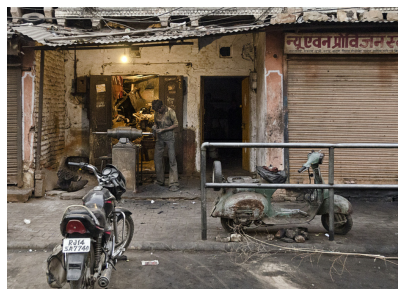

In [38]:
#Show images of COCO
for sample in train_dataset.take(1):
    image = tf.cast(sample["image"], dtype=tf.float32)

    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.imshow(image)

In [39]:
#Exploring TFrecord estructure
for sample in train_dataset.take(1):
    print(sample["objects"])

{'area': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17821, 16942,  4344])>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.54380953, 0.13464062, 0.98651516, 0.33742186],
       [0.50707793, 0.517875  , 0.8044805 , 0.891125  ],
       [0.3264935 , 0.36971876, 0.65203464, 0.4431875 ]], dtype=float32)>, 'id': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([152282, 155195, 185150])>, 'is_crowd': <tf.Tensor: shape=(3,), dtype=bool, numpy=array([False, False, False])>, 'label': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 3, 0])>}


In [40]:
#Exploring TFrecord estructure

for sample in train_dataset.take(1):
    
    print(sample['objects'], "\n\n")
    print(sample['objects']['label'])
    #image = tf.cast(sample["image"], dtype=tf.float32)
    
    #image = np.array(image, dtype=np.uint8)
    #plt.figure(figsize=(7, 7))
    #plt.axis("off")
    #plt.imshow(image)

{'area': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([17821, 16942,  4344])>, 'bbox': <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0.54380953, 0.13464062, 0.98651516, 0.33742186],
       [0.50707793, 0.517875  , 0.8044805 , 0.891125  ],
       [0.3264935 , 0.36971876, 0.65203464, 0.4431875 ]], dtype=float32)>, 'id': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([152282, 155195, 185150])>, 'is_crowd': <tf.Tensor: shape=(3,), dtype=bool, numpy=array([False, False, False])>, 'label': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([3, 3, 0])>} 


tf.Tensor([3 3 0], shape=(3,), dtype=int64)


# Importing my own dataset (the error occurs here)

In [ ]:
cd '/content'

In [ ]:
%%bash
curl -L "https://app.roboflow.com/ds/XqoiwGXC8L?key=NyDE34g8vI" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [57]:
BUFFER_SIZE = 1000
BATCH_SIZE = 16

PATH_TFRECORDS_TRAIN='/content/train/racoon.tfrecord'

filepaths = [str(PATH_TFRECORDS_TRAIN)]
train_dataset = tf.data.TFRecordDataset(filepaths).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [58]:
for item in train_dataset.take(1):
    print(item)

tf.Tensor(
[b'\n\x9f\xc8\x01\n\xa9\xc5\x01\n\rimage/encoded\x12\x96\xc5\x01\n\x92\xc5\x01\n\x8e\xc5\x01\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x01\xa0\x01\xa0\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5

In [59]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf, PIL.Image, numpy as np

raw_dataset = tf.data.TFRecordDataset(PATH_TFRECORDS_TRAIN)

In [ ]:
for i, raw_record in enumerate(raw_dataset.take(3)):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    info = {}
    for k, v in example.features.feature.items():
      print(k, v)

In [ ]:
#DO AUGMENTATION ON TFRECORDS
https://stackoverflow.com/questions/65007191/how-to-read-decode-tfrecords-file-see-the-images-inside-and-do-augmentation

In [ ]:
#Show images of COCO
for sample in test_dataset.take(1):
    image = tf.cast(sample["image"], dtype=tf.float32)

    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.imshow(image)

## Setting up a `tf.data` pipeline

To ensure that the model is fed with data efficiently we will be using
`tf.data` API to create our input pipeline. The input pipeline
consists for the following major processing steps:

- Apply the preprocessing function to the samples
- Create batches with fixed batch size. Since images in the batch can
have different dimensions, and can also have different number of
objects, we use `padded_batch` to the add the necessary padding to create
rectangular tensors
- Create targets for each sample in the batch using `LabelEncoder`

In [64]:
autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

TypeError: ignored

## Training the model

In [ ]:
"""ORIGINAL"""
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size

# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 2

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

model.fit(
    train_dataset.take(50),
    validation_data=val_dataset.take(25),
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

#Save weights"""""""

## Loading MS COCO 2017 weights

In [ ]:
# Change this to `model_dir` when not using the downloaded weights
weights_dir = "data"

#weights_dir = model_dir

"""Finds the filename of latest saved checkpoint file."""
#In this case, are they the best weights? I think so.
latest_checkpoint = tf.train.latest_checkpoint(weights_dir)

"""Load the weights"""
model.load_weights(latest_checkpoint)

## Building inference model

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

## Generating detections

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, jitter=None)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

#only works if this line is uncommented
val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str

for sample in val_dataset.take(1):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    
    """Do inference"""
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    print(num_detections)
    
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

In [ ]:
train_dataset = tfds.load("coco/2017", split="train", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str  

#Show images of COCO
for sample in train_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)

    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=(7, 7))
    plt.axis("off")
    plt.imshow(image)

In [ ]:
#only works if this line is uncommented
train_dataset = tfds.load("coco/2017", split="train", data_dir="data")
int2str = dataset_info.features["objects"]["label"].int2str 

for sample in train_dataset.take(1):
#    image = tf.cast(sample["image"], dtype=tf.float32)
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    #print(bbox)
    
    image = tf.cast(sample["image"], dtype=tf.float32)

    input_image, ratio = prepare_image(image)
    
    """Do inference"""
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    print(type(detections))
    
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )